# SVM vs CE

### Reproduction of Figure # 01
#### Paper: https://openreview.net/forum?id=ByfbnsA9Km

In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

In [2]:
# Create the data
def create_binary_classification_dataset(num_points=50):
    # Define the classes span
    cls_zero_x = np.full(shape=(num_points, 1), fill_value=2)
    cls_one_x = np.full(shape=(num_points, 1), fill_value=5)
    
    cls_zero_y = np.random.uniform(low=40, high=50, size=(num_points, 1))
    cls_one_y = np.random.uniform(low=70, high=80, size=(num_points, 1))
    
    X_zero = np.concatenate([cls_zero_x, cls_zero_y], axis=1)
    X_one = np.concatenate([cls_one_x, cls_one_y], axis=1)
    
    X = np.concatenate([X_zero, X_one])
    y = np.zeros([X.shape[0], 1])
    y[X_zero.shape[0]:] = 1.0
    
    permutation = np.random.permutation(num_points * 2)
    X = X[permutation]
    y = y[permutation]
    
    print("Data shape | X: %s | y: %s" % (str(X.shape), str(y.shape)))
    
    return X, y

In [3]:
# Create the dataset
X_np, y_np = create_binary_classification_dataset()

Data shape | X: (100, 2) | y: (100, 1)


In [4]:
print(X_np[:10, :])
print(y_np[:10, :])

[[ 5.         71.35392655]
 [ 5.         75.66180091]
 [ 2.         43.28770015]
 [ 5.         75.7510762 ]
 [ 5.         77.29285472]
 [ 5.         72.40907723]
 [ 5.         79.42229039]
 [ 2.         44.88304599]
 [ 2.         48.43231164]
 [ 5.         70.5015501 ]]
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [5]:
# Define the network
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(2, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        # x = self.sigmoid(x)
        return x

In [6]:
model = LinearModel()
if torch.cuda.is_available():
    model.cuda()

In [7]:
# Define the loss
loss = torch.nn.BCEWithLogitsLoss()

In [8]:
# Convert the data to torch variables
X = torch.autograd.Variable(torch.from_numpy(X_np)).float()
y = torch.autograd.Variable(torch.from_numpy(y_np)).float()
if torch.cuda.is_available():
    X = X.cuda()
    y = y.cuda()

In [9]:
print(X[:10, :])
print(y[:10, :])

tensor([[ 5.0000, 71.3539],
        [ 5.0000, 75.6618],
        [ 2.0000, 43.2877],
        [ 5.0000, 75.7511],
        [ 5.0000, 77.2929],
        [ 5.0000, 72.4091],
        [ 5.0000, 79.4223],
        [ 2.0000, 44.8830],
        [ 2.0000, 48.4323],
        [ 5.0000, 70.5015]], device='cuda:0')
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]], device='cuda:0')


In [10]:
# Define the optimizer
optim = torch.optim.SGD(model.parameters(), lr=1.0)

In [11]:
model.train()
num_epochs = 200
log_iter = 10
for epoch in range(num_epochs):
    # Obtain the predictions
    output = model(X)
    
    # Perform the update
    optim.zero_grad()
    current_loss = loss(output, y)
    current_loss.backward()
    optim.step()
    
    if epoch % log_iter == log_iter - 1:
        print("Epoch: %d | Loss: %f" % (epoch+1, current_loss.item()))

Epoch: 10 | Loss: 828.169495
Epoch: 20 | Loss: 322.306580
Epoch: 30 | Loss: 115.468643
Epoch: 40 | Loss: 429.203888
Epoch: 50 | Loss: 742.939209
Epoch: 60 | Loss: 451.072906
Epoch: 70 | Loss: 30.238329
Epoch: 80 | Loss: 343.973633
Epoch: 90 | Loss: 0.000002
Epoch: 100 | Loss: 0.000002
Epoch: 110 | Loss: 0.000002
Epoch: 120 | Loss: 0.000002
Epoch: 130 | Loss: 0.000001
Epoch: 140 | Loss: 0.000001
Epoch: 150 | Loss: 0.000001
Epoch: 160 | Loss: 0.000001
Epoch: 170 | Loss: 0.000001
Epoch: 180 | Loss: 0.000001
Epoch: 190 | Loss: 0.000001
Epoch: 200 | Loss: 0.000001


In [12]:
# Set the model to test mode
model.eval()

# Create the decision boundary
plot_3d = True
use_circle = False
axis_limits = [[-20, 50], [30, 90]]
num_values = [axis_limits[0][1] - axis_limits[0][0], axis_limits[1][1] - axis_limits[1][0]]
grid_dims = [list(range(axis_limits[0][0], axis_limits[0][1])), list(range(axis_limits[1][0], axis_limits[1][1]))]
if plot_3d:
    grid = np.full(shape=num_values + [4], fill_value=0.1)
    grid[:, :, -1] = np.full(shape=num_values, fill_value=0.75)
else:
    grid = np.zeros(num_values)
    
for idx, i in enumerate(grid_dims[0]):
    for idy, j in enumerate(grid_dims[1]):
        x = torch.from_numpy(np.array([i, j], dtype=np.float32))
        if torch.cuda.is_available():
            x = x.cuda()
        current_y = torch.sigmoid(model(x))
        current_y = current_y.item() > 0.5
        if plot_3d:
            if current_y:
                if use_circle:
                    cv2.circle(grid, (idy, idx), 1, (1.0, 1.0, 1.0, 0.5), -1)
                else:
                    grid[idx, idy, :] = [1.0, 1.0, 1.0, 0.5]
        else:
            grid[idx, idy] = current_y
            
# Plot the data points
for idx, x in enumerate(X_np):
    # Correct for axis scaling
    current_x = X_np[idx, :].copy()
    current_x[0] = int(round(current_x[0] - axis_limits[0][0]))
    current_x[1] = int(round(current_x[1] - axis_limits[1][0]))
    
    current_y = y_np[idx]
    # print("Final Point: (%d, %d)" % (current_x[0], current_x[1]))
    if plot_3d:
        if use_circle:
            cv2.circle(grid, (int(current_x[1]), int(current_x[0])), 1, (1.0, 0.0, 0.0, 0.5) if (current_y > 0.5) else (0.0, 1.0, 0.0, 0.5), -1)
        else:
            grid[int(current_x[0]), int(current_x[1]), :] = [1.0, 0.0, 0.0, 0.5] if (current_y > 0.5) else [0.0, 1.0, 0.0, 0.5]
    else:
        grid[idx, idy] = 0.75 if (current_y > 0.5) else 0.25
        
grid = np.transpose(grid, [1, 0, 2])
grid = grid[::-1, :, :]

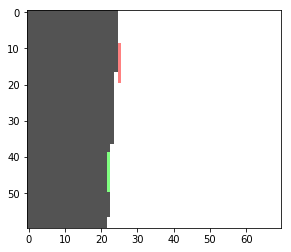

In [13]:
#plt.plot(grid)
# plt.xlim(axis_limits[0])
# plt.ylim(axis_limits[1])
plt.imshow(grid)
plt.show()